In [1]:
import numpy as np
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [2]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics

def build_model(x_train):

    '''This script demonstrates how to build a variational autoencoder with Keras.

     #Reference

     - Auto-Encoding Variational Bayes
       https://arxiv.org/abs/1312.6114
    '''


    batch_size = 20
    original_dim=x_train.shape[1]
    latent_dim = 32
    intermediate_dim = 500
    epochs = 10
    epsilon_std = 1.0


    x = Input(shape=(original_dim,))
    h = Dense(256, activation='tanh')(x)
    h = Dense(128, activation='tanh')(h)
    h = Dense(64, activation='tanh')(h)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)


    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # we instantiate these layers separately so as to reuse them later

    h_decoded = Dense(64, activation='tanh')(z)
    h_decoded = Dense(128, activation='tanh')(h_decoded)
    h_decoded = Dense(256, activation='tanh')(h_decoded)
    x_decoded_mean = Dense(original_dim, activation='sigmoid')(h_decoded)

    # instantiate VAE model
    vae = Model(x, x_decoded_mean)

    # Compute VAE loss
    xent_loss = original_dim * metrics.binary_crossentropy(x,x_decoded_mean )
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)

    vae.add_loss(vae_loss)
    from keras import optimizers
    rmsprop=optimizers.RMSprop(lr=0.00001, rho=0.9, epsilon=None, decay=0.0)
    vae.compile(optimizer=rmsprop)
    vae.summary()


    vae.fit(x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size)

    encoder = Model(x, z_mean)


    return encoder

Using TensorFlow backend.


In [3]:
from nilearn.decomposition import CanICA
def prepare_data(func_filenames):
    canica = CanICA(memory="nilearn_cache", memory_level=2,
                    threshold=3., verbose=10, random_state=0, 
                    mask='/home/share/TmpData/Qinglin/ADHD200_Athena_preproc_flirtfix/ADHD200_mask_152_4mm.nii.gz')
    data=canica.prepare_data(func_filenames)
    return data

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
from nilearn.connectome import ConnectivityMeasure

def corr(all_time_series):
    connectivity_biomarkers = {}
    conn_measure = ConnectivityMeasure(kind='correlation', vectorize=True)
    connectivity_biomarkers = conn_measure.fit_transform(all_time_series)
    return connectivity_biomarkers

In [5]:
from nilearn.connectome import ConnectivityMeasure

def corr_tan(all_time_series):
    connectivity_biomarkers = {}
    tangent_measure = ConnectivityMeasure(kind='tangent', vectorize=True)
    connectivity_biomarkers = tangent_measure.fit_transform(all_time_series)
    return connectivity_biomarkers


In [6]:
D=np.load('/home/share/TmpData/Qinglin/ABIDE/all_time_series_64.npy')
Y=np.load('/home/share/TmpData/Qinglin/ABIDE/Y.npy')

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

names = ["Nearest Neighbors", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA","XGBoost","Bagging","GTBoosting"]

classifiers = [
    KNeighborsClassifier(3),
#         SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
#         GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=100, max_features=1),
    MLPClassifier(hidden_layer_sizes=(500,400,300,200,100,50)),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    XGBClassifier(),
    BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)]

from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

from sklearn.model_selection import cross_val_score
mean_scores = []


for name, clf in zip(names, classifiers):
    cv_scores = cross_val_score(clf,
                                corr_tan(D),
                                y=Y,
                                cv=cv,
                                groups=Y,
                                scoring='accuracy',
                                )
    mean_scores.append(cv_scores.mean())

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.5/dist-packages/skl

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


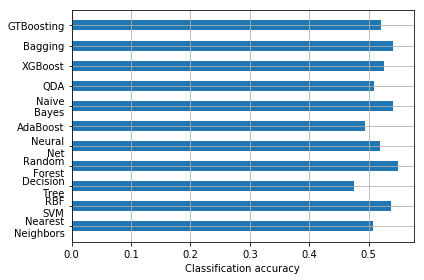

In [8]:
from nilearn.plotting import show
import matplotlib.pylab as plt

plt.figure(figsize=(6, 4))
positions = np.arange(len(names)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05)
yticks = [name.replace(' ', '\n') for name in names]
plt.yticks(positions, yticks)
plt.xlabel('Classification accuracy')
plt.grid(True)
plt.tight_layout()

show()